<a href="https://colab.research.google.com/github/bbchen33/Data-Science/blob/master/Bank_churn_survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank customer churn analysis. 
# Who churns?



Data source https://www.kaggle.com/shrutimechlearn/churn-modelling

In [2]:
!unzip 'bank-churn-modelling.zip'

Archive:  bank-churn-modelling.zip
  inflating: Churn_Modelling.csv     


In [0]:
import pandas as pd
df = pd.read_csv('Churn_Modelling.csv')

In [4]:
df.describe(include = 'all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


I noticed that there is a column called "IsActiveNumber" and it is not consistent with the values in the "Exited" column. It's good to know that the company might have different definitions for being "inactive" and having "churned". 

In [40]:
df[['IsActiveMember', 'Exited']][:5]

,IsActiveMember,Exited
0,1,1
1,1,0
2,0,1
3,0,0
4,1,0


In [5]:
df.Exited.value_counts() # about 4 times more people who haven't churned than who have.

0    7963
1    2037
Name: Exited, dtype: int64

In [6]:
!pip install --quiet lifelines #using the lifelines package to perform survival analysis

     |████████████████████████████████| 419kB 2.8MB/s 


A very quick example on showing how the Kaplan Meier curve can be used to show how the customers churn based on specific feature they have. In this case, having a credit card is used as the feature and it seems like credit card is not a key factor for churn rate. 

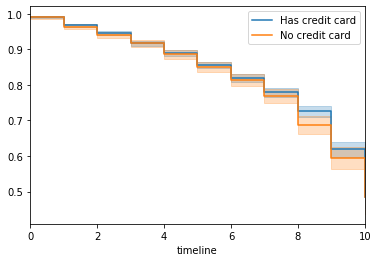

In [15]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
groups = df['HasCrCard']
credit_card = (groups == 1)
no_credit_card = (groups == 0)

ax = plt.subplot()
kmf.fit(df.Tenure[credit_card], df.Exited[credit_card], label = 'Has credit card')
ax = kmf.plot(ax = ax)
kmf.fit(df.Tenure[no_credit_card], df.Exited[no_credit_card], label = 'No credit card')
ax = kmf.plot(ax = ax)

# Now that we see that credit card is not a key factor, we can try Cox Proportional Hazards model to understand the importance of each feature.

To demonstrate the importance of turning continuous feature like "Age" to categories when I want to determine its role in churn, I am comparing using a continuous version vs categorical version of "Age".

In [0]:
df_features = df[['Tenure', 'Exited', 'Age', 'HasCrCard']]

In [83]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_features, 'Tenure', event_col = 'Exited')
cph.print_summary()

Both the "Age" and "HasCrCard" have coefficient close to 0, meaning they don't have a significant role in churn rate. This is using continuous version of the "Age" feature.

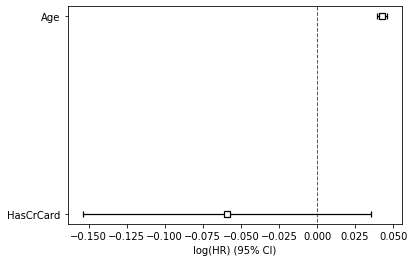

In [84]:
cph.plot()

Now I'm using categorical feature of "Age" by first breaking the numbers into bins and then converting the bins to categories. 

In [0]:
df['Age_bins'] = pd.cut(df['Age'], bins = 5)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['transformed_age'] = le.fit_transform(df['Age_bins'])

In [0]:
df_features = df[['Tenure', 'Exited', 'transformed_age', 'HasCrCard']]

In [89]:
cph = CoxPHFitter()
cph.fit(df_features, 'Tenure', event_col = 'Exited')
cph.print_summary()

Now the coefficient for "transformed_age" is 0.6. It is a huge difference. Age has a role in the churn rate.

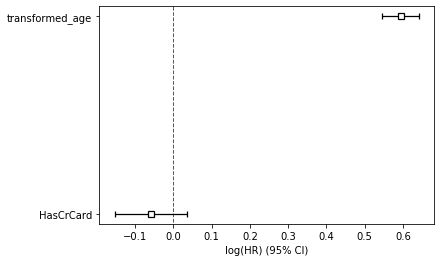

In [90]:
cph.plot() 

Now I know I can do the same thing for all the continuous features. 

In [91]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Age_bins',
       'transformed_age'],
      dtype='object')

In [0]:
for column in ['CreditScore','Balance', 'EstimatedSalary']:
  df[f'{column}_bins'] = pd.cut(df[column], bins = 10)

In [101]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bins,transformed_age,Balance_bins,EstimatedSalary_bins,CreditScore_bins
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(32.8, 47.6]",1,"(-250.898, 25089.809]","(100002.03, 120000.12]","(600.0, 650.0]"
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(32.8, 47.6]",1,"(75269.427, 100359.236]","(100002.03, 120000.12]","(600.0, 650.0]"
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(32.8, 47.6]",1,"(150538.854, 175628.663]","(100002.03, 120000.12]","(500.0, 550.0]"


In [102]:
df_features_transformed = df_features[['Tenure', 'Exited']]
for column in ['CreditScore_bins', 'Geography', 'Gender', 'Age_bins', 'Balance_bins', 'EstimatedSalary_bins', 'CreditScore_bins']:
  le.fit(df[column])
  df_features_transformed[f'transformed_{column}'] = le.transform(df[column])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [103]:
df_features_transformed.head(5)

,Tenure,Exited,transformed_CreditScore_bins,transformed_Geography,transformed_Gender,transformed_Age_bins,transformed_Balance_bins,transformed_EstimatedSalary_bins
0,2,1,5,0,0,1,0,5
1,1,0,5,2,0,1,3,5
2,8,1,3,0,0,1,6,5
3,1,0,6,0,0,1,0,4
4,2,0,9,2,0,1,5,3


In [104]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_features_transformed, 'Tenure', event_col = 'Exited')

<lifelines.CoxPHFitter: fitted with 10000 total observations, 7963 right-censored observations>

In [105]:
cph.print_summary()

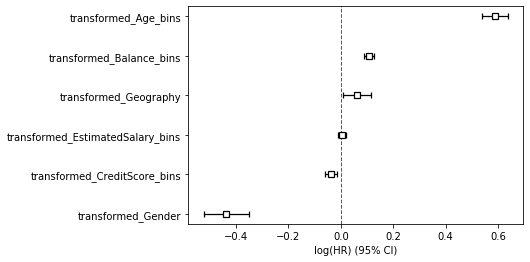

In [106]:
cph.plot()

Now it's easy to see that "Age" and "Gender" are important factors for churn.